In [1]:
import numpy as np
import pandas as pd
import scipy
import random
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import interp1d
from celluloid import Camera
import pymc as pm
import aesara.tensor as T
import aesara
import arviz as az
import graphviz 
import pytensor
import pytensor.tensor as pt


RANDOM_SEED = 123
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
aesara.config.compute_test_value='ignore'
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# (n-1)th order polynomial 
def polynomial(params, x):
    ans = np.zeros(x.shape[0])
    for p in range(x.shape[0]):
        for i in range(params.shape[0]):
            ans[p] += params[i]*(x[p]**i)
    return ans

# Cost function for parameter optimization 
def cost(params, x, y):
    ans = np.sum((y-polynomial(params, x))**2)
    return ans

# Cost function (+ regulation term) for parameter optimization
def cost_regulation(params, x, y, lmd):
    ans = np.sum((y-polynomial(params, x))**2) + lmd*np.sum(params**2)
    return ans

def create_sampledata(num):
    idx = np.arange(num) 
    x = np.zeros(num)
    y = np.zeros(num)

    for i in idx:
        noise = np.random.normal(0,0.1)
        x[i] = random.uniform(0, 1)
        y[i] = np.sin(2*np.pi*x[i]) + noise
    return x, y

# Optimizer set-up    
def optimize_params(x, y, n, lmd):
    init = np.ones(n)
    bounds = []
    for i in range(n):
        bounds.append((-10, 10))
    ans = scipy.optimize.minimize(cost_regulation,
            init,
            args = (x, y, lmd),
            tol = 1e-20)
    ans_params = ans.x 
    return ans_params

# Draw different orders' polynomial in one chance
def draw_graph(x,y,ans_params,fig,ax,n):
    data = ax.scatter(x, y, alpha =0.5, c = 'dodgerblue')
    x_tick = np.linspace(0,1,50)
    graph = ax.plot(x_tick, polynomial(ans_params,x_tick), c = 'orange', alpha = 0.8)
    ax.set_ylim(-1.25,1.25)
    ax.set_xlim(0,1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')  
    ax.legend(graph, ["Order number: {}".format(n)], loc= 'upper right')
    return fig, ax 

In [27]:
num_data = 15

# Create ramdom sample data points [0,1] following y = sin x 
x_data, y_data = create_sampledata(num_data) 

df = pd.DataFrame()
df['x'] = x_data.flatten().tolist()
df['y'] = y_data.flatten().tolist()

n = 4 # number of polynomial coefficients
lmd = 0 

with pm.Model() as model:
    x = pm.MutableData("x", df.x)
    w_mu = pm.Normal('w_mu', mu=0., sigma = 1)
    w_sigma = pm.HalfNormal('w_sigma', sigma = 10 )
    w = pm.Normal('w', mu= w_mu, sigma = w_sigma, shape=n)
    mu = pm.Deterministic("mu", sum(((w[i]*(x**i)) for i in range(n))))
    #TODO: how to improve w[i]*(x**i) form into matrix...? 
    
    likelihood_sigma = pm.HalfNormal('likelihood_sigma', sigma = 10)
    likelihood = pm.Normal("y", mu = mu, sigma = likelihood_sigma, observed = df.y)

with model:
    step = pm.Metropolis()
    samples = pm.sample()
    pm.model_to_graphviz(model)

ERROR (aesara.graph.rewriting.basic): Rewrite failure due to: transform_values
ERROR (aesara.graph.rewriting.basic): node: halfnormal_rv{0, (0, 0), floatX, False}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2C496B040>), TensorConstant{[]}, TensorConstant{11}, TensorConstant{0.0}, TensorConstant{10.0})
ERROR (aesara.graph.rewriting.basic): TRACEBACK:
ERROR (aesara.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/jinyoungko/anaconda3/lib/python3.9/site-packages/aesara/graph/rewriting/basic.py", line 1933, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/jinyoungko/anaconda3/lib/python3.9/site-packages/aesara/graph/rewriting/basic.py", line 1092, in transform
    return self.fn(fgraph, node)
  File "/Users/jinyoungko/anaconda3/lib/python3.9/site-packages/aeppl/transforms.py", line 158, in transform_values
    new_value_var = transformed_variable(
  File "/Users/jinyoungko/anaconda3/lib/python3.9/site-packages/aesara/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
There were 685 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.07797, but should be close to 0.8. Try to increase the number of tuning steps.
There were 323 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3213, but should be close to 0.8. Try to increase the number of tuning steps.
There were 164 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5391, but should be close to 0.8. Try to increase the number of tuning steps.
There were 486 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.16, but should be close to 0.8. Try to increase the number of tuning step

array([[<AxesSubplot:title={'center':'w_mu'}>,
        <AxesSubplot:title={'center':'w_mu'}>],
       [<AxesSubplot:title={'center':'w'}>,
        <AxesSubplot:title={'center':'w'}>],
       [<AxesSubplot:title={'center':'w_sigma'}>,
        <AxesSubplot:title={'center':'w_sigma'}>],
       [<AxesSubplot:title={'center':'likelihood_sigma'}>,
        <AxesSubplot:title={'center':'likelihood_sigma'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>]], dtype=object)

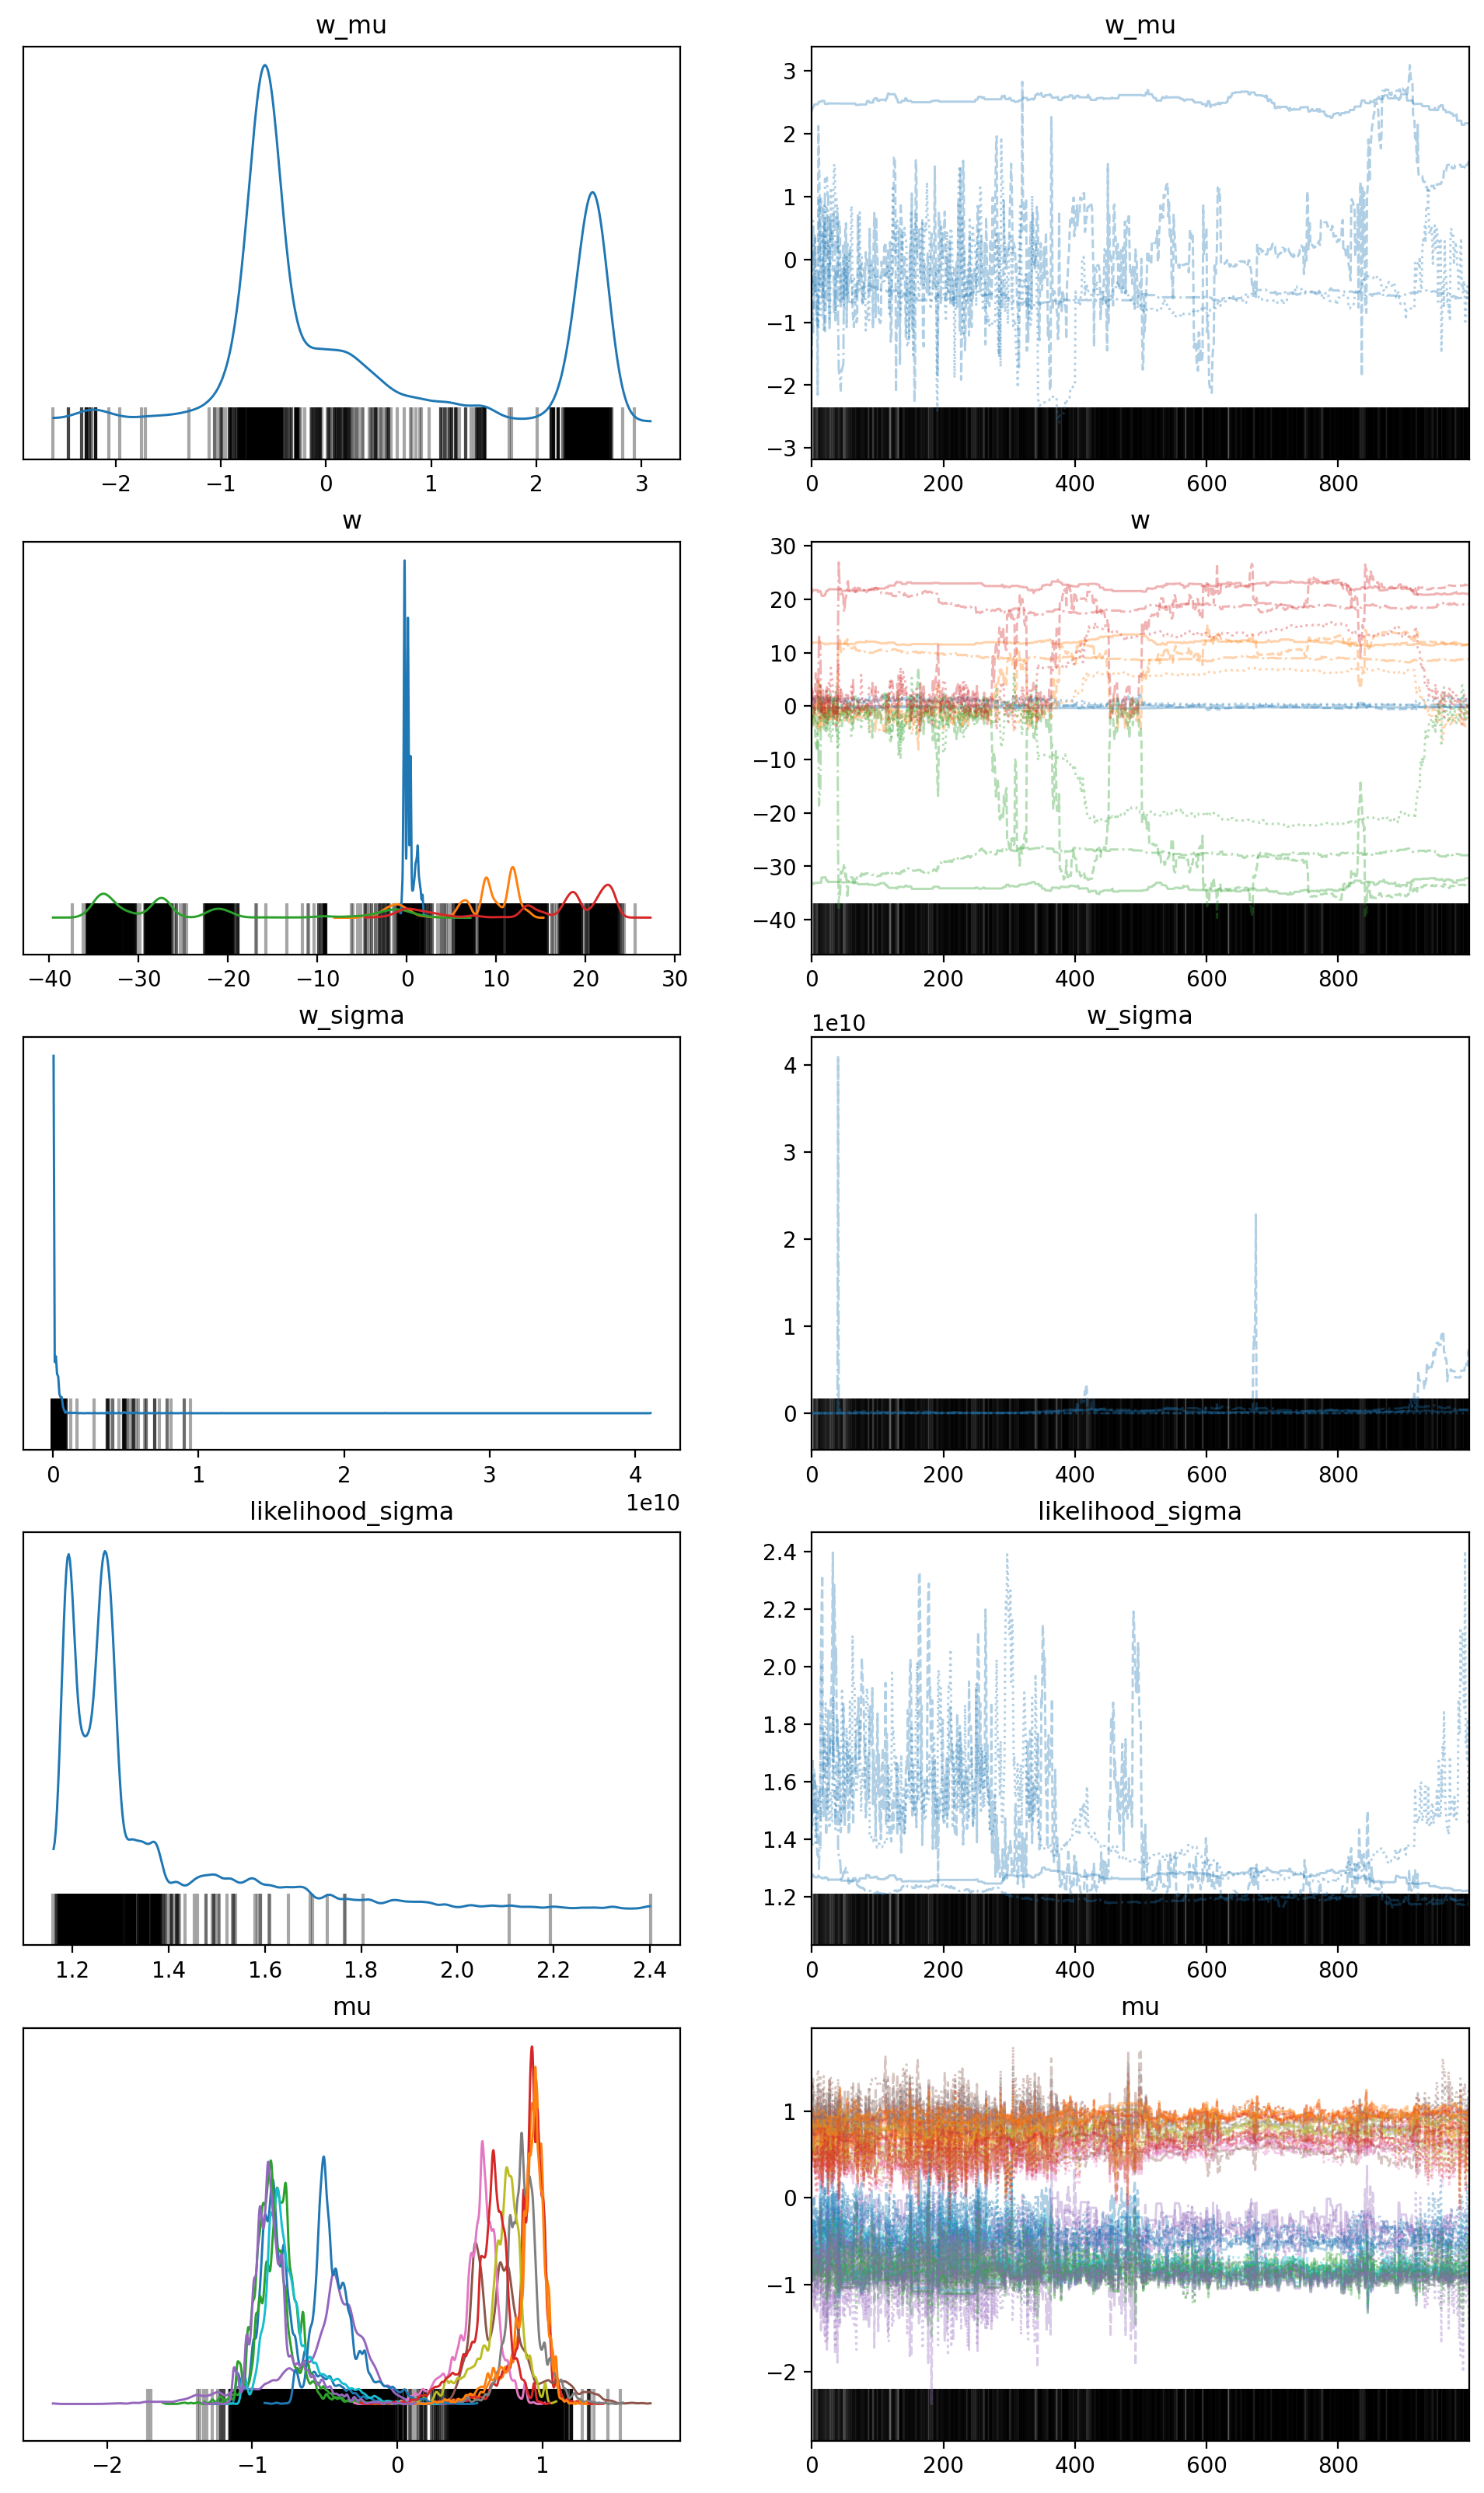

In [28]:
plt.style.use('default')
pm.plot_trace(samples, filter_vars="like", combined=True, kind="trace", figsize = (12,20))

In [29]:
x_tick = np.linspace(0,1,100)
#samples.posterior['w'][::100][0][:,0]
w_infered = samples.posterior['w'][::100][0]

y_samples = [sum(w_infered[:,i]*(x_tick[j]**i) for i in range(n)) for j in range(x_tick.shape[0])]
y_med = np.median(y_samples, axis = 1)
y_u = np.percentile(y_samples, axis = 1, q = 97.5)
y_l = np.percentile(y_samples, axis = 1, q = 2.5)

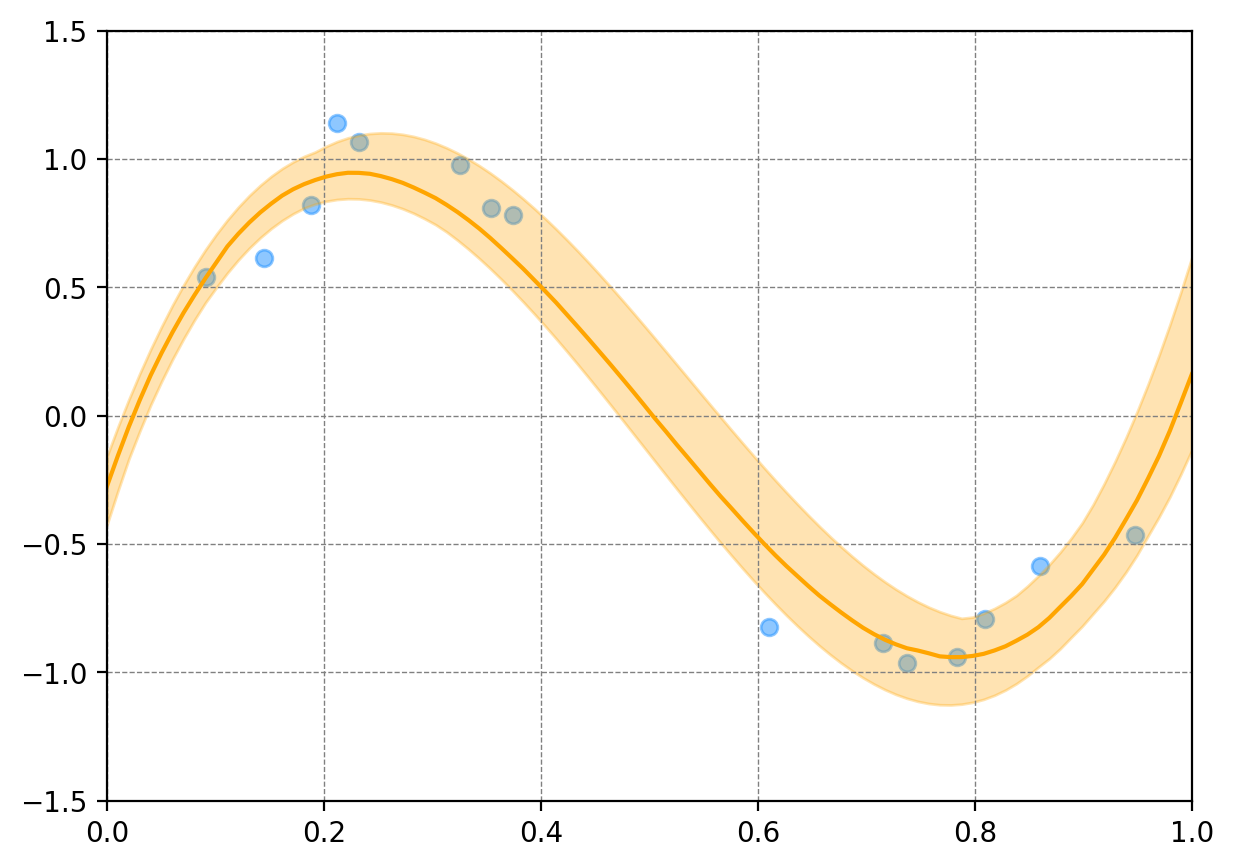

In [30]:
plt.style.use('default')
available = ['default'] + plt.style.available

fig, ax = plt.subplots(figsize=(7,5))

ax.scatter(x_data, y_data, alpha =0.5, c = 'dodgerblue')
ax.plot(x_tick, y_med, 'orange')
ax.fill_between(x_tick, y_l, y_u, alpha = 0.3, color = 'orange')
ax.set_xlim(0,1)
ax.set_ylim(-1.5,1.5)
ax.grid(color='grey', linestyle='--', linewidth= 0.5)
